# Ten-Bar Truss Weight Minimization
Created by Yi-Ping Chen, last modified in Jan. 2025 for ME341.

In [17]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import random
import math

### Define functions

In [18]:
def FEA(r):
    """
    2D FEA for the 10-bar truss, given r=[r1, r2].
    Returns:
      length_e (array of element lengths),
      stress   (array of element stresses),
      r_e      (array of 10 radii, first 6 = r1, last 4 = r2),
      Q        (nodal displacements, size=12).
    """
    length = 9.14
    E = 200e9
    # External forces (N)
    F = np.zeros(12)
    F[3] = -1e7  # Node #2 in -y
    F[7] = -1e7  # Node #4 in -y

    # Node coords (6 nodes), scaled by length
    n = np.array([
        [2,1],[2,0],[1,1],[1,0],[0,1],[0,0]
    ]) * length

    # Element connectivity (10 bars), zero-based
    ec = np.array([
        [3,5],[1,3],[4,6],[2,4],[3,4],
        [1,2],[4,5],[3,6],[2,3],[1,4]
    ]) - 1

    num_elems = ec.shape[0]
    length_e = np.zeros(num_elems)
    l = np.zeros(num_elems)
    m = np.zeros(num_elems)

    # Compute each bar's length & direction cosines
    for i in range(num_elems):
        diff = n[ec[i,1]] - n[ec[i,0]]
        length_e[i] = np.linalg.norm(diff)
        l[i] = diff[0]/length_e[i]
        m[i] = diff[1]/length_e[i]

    # Radii: first 6 bars => r1, last 4 => r2
    r_e = np.concatenate([np.full(6, r[0]), np.full(4, r[1])])
    A = np.pi*(r_e**2)  # cross-sectional areas

    # Build global stiffness
    K = np.zeros((12,12))
    for i in range(num_elems):
        k_small = (E*A[i]/length_e[i]) * np.array([
            [l[i]**2,    l[i]*m[i]],
            [l[i]*m[i],  m[i]**2]
        ])
        idx = [
            ec[i,0]*2, ec[i,0]*2+1,
            ec[i,1]*2, ec[i,1]*2+1
        ]
        # Insert sub-block
        block = np.zeros((4,4))
        block[:2,:2]   = k_small
        block[2:,2:]   = k_small
        block[:2,2:]   = -k_small
        block[2:,:2]   = -k_small
        # Assemble
        for rr in range(4):
            for cc in range(4):
                K[idx[rr], idx[cc]] += block[rr, cc]

    # Solve for unknown DOFs => first 8 free, last 4 fixed
    K_reduced = K[:8,:8]
    F_reduced = F[:8]
    Q_reduced = np.linalg.solve(K_reduced, F_reduced)
    Q = np.concatenate([Q_reduced, np.zeros(4)])  # total 12 DOFs

    # Compute stress in each bar
    stress = np.zeros(num_elems)
    for i in range(num_elems):
        idx = [
            ec[i,0]*2, ec[i,0]*2+1,
            ec[i,1]*2, ec[i,1]*2+1
        ]
        vec = np.array([-l[i], -m[i], l[i], m[i]])
        stress[i] = (E/length_e[i]) * np.dot(vec, Q[idx])

    return length_e, stress, r_e, Q


# Nonlinear constraints
def nonlincon(r):
    """
    g_i(r) <= 0 => feasible.
    Buckling, yield stress, and displacement at node #2 (DOFs #2,3).
    """
    length_e, stress, r_e, Q = FEA(r)
    E = 200e9
    Y = 250e6
    I = (np.pi/4)* (r_e**4)

    # Max displacement
    dis_max = 0.02  # 2 cm

    num_elems = len(stress)
    g_buckling = np.zeros(num_elems)
    g_stress   = np.zeros(num_elems)

    # Internal force = A*sigma
    F_internal = np.pi*(r_e**2)*stress

    for i in range(num_elems):
        # Buckling if in compression
        if F_internal[i] < 0:
            F_comp = -F_internal[i]
            crit_buckle = (np.pi**2 * E * I[i]) / (length_e[i]**2)
            g_buckling[i] = F_comp - crit_buckle  # >0 => violation
        else:
            g_buckling[i] = -1e-6  # safely negative => not violated

        # Stress => |sigma| <= Y
        g_stress[i] = abs(stress[i]) - Y

    # Displacement at node #2 => sqrt(Q[2]^2 + Q[3]^2) <= dis_max
    # => Q[2]^2+Q[3]^2 - dis_max^2 <= 0
    disp_constraint = (Q[2]**2 + Q[3]**2) - (dis_max**2)

    # Concatenate all => if ANY >0 => infeasible
    return np.concatenate([g_buckling, g_stress, [disp_constraint]])

# Define objective function
def obj(r):
    length = 9.14
    density = 7860
    weight = (6 * np.pi * r[0]**2 * length + 4 * np.pi * r[1]**2 * length * np.sqrt(2)) * density
    return weight

def is_feasible(x):
    g = nonlincon(x)
    return np.all(g <= 0)

def penalty_function(r, alpha=1e16):
    g = nonlincon(r)
    viol = g[g>0]
    return alpha * np.sum(viol**2) if len(viol) else 0.0

def energy(r):
    return obj(r) + penalty_function(r)

### Example Optimizer Setup

In [19]:
"""

# Initial conditions and bounds
r0 = [0.2, 0.3]  # Initial guess
bounds = [(0.01, 0.5), (0.01, 0.5)]  # Bounds for r1 and r2

# Solve optimization problem
result = minimize(
    fun=obj,
    x0=r0,
    method='COBYLA', # The only two options on Scipy.minimize that takes constraints as dictionary are SLSQP and COBYLA. SLSQP won't work in this case. 
    bounds=bounds,
    constraints=[{
        'type': 'ineq',  # Inequality constraints: g <= 0
        'fun': nonlincon
    }],
    options={'disp': True}  # Display detailed optimization output
)

# Extract results
xBest = result.x
fval = result.fun
"""

"\n\n# Initial conditions and bounds\nr0 = [0.2, 0.3]  # Initial guess\nbounds = [(0.01, 0.5), (0.01, 0.5)]  # Bounds for r1 and r2\n\n# Solve optimization problem\nresult = minimize(\n    fun=obj,\n    x0=r0,\n    method='COBYLA', # The only two options on Scipy.minimize that takes constraints as dictionary are SLSQP and COBYLA. SLSQP won't work in this case. \n    bounds=bounds,\n    constraints=[{\n        'type': 'ineq',  # Inequality constraints: g <= 0\n        'fun': nonlincon\n    }],\n    options={'disp': True}  # Display detailed optimization output\n)\n\n# Extract results\nxBest = result.x\nfval = result.fun\n"

### PT - SA Algorithm V3

In [20]:
def parallel_tempering_sa(pt_config):
    """
    Parallel Tempering SA:
      - r0_list: initial guesses for each chain
      - T0_list: initial temperatures for each chain
      - bounds
      - max_iter, swap_interval, adapt_interval
      - step_size_init, adapt_factor
      - no_improve_limit
      - min_temp, cooling_rate
      - etc.
    Returns (best_solution, best_energy, logs).
    logs => {
      "temp_history", "accept_history", "best_history", "chain_paths"
    }
    """
    r0_list = pt_config["r0_list"]
    T0_list = pt_config["T0_list"]
    bounds = pt_config["bounds"]
    max_iter = pt_config.get("max_iter", 2000)
    swap_interval = pt_config.get("swap_interval", 200)
    adapt_interval= pt_config.get("adapt_interval", 100)
    step_size_init=pt_config.get("step_size_init", 0.01)
    adapt_factor  =pt_config.get("adapt_factor", 1.2)
    no_improve_limit=pt_config.get("no_improve_limit", 500)
    min_temp      =pt_config.get("min_temp", 1e-9)
    cooling_rate  =pt_config.get("cooling_rate", 0.98)
    seed          =pt_config.get("seed", 0)

    random.seed(seed)
    np.random.seed(seed)

    n_chains = len(r0_list)
    assert n_chains == len(T0_list), "Number of chains must match T0_list length."

    def clamp(r):
        return [
            min(max(r[i], bounds[i][0]), bounds[i][1])
            for i in range(len(r))
        ]
    def get_neighbor(x, st):
        y = x[:]
        idx = random.randint(0, len(x)-1)
        y[idx] += random.uniform(-st, st)
        return clamp(y)

    # Initialize chains
    chain_r = [clamp(r0_list[i]) for i in range(n_chains)]
    chain_E = [energy(rr) for rr in chain_r]
    chain_T = [T0_list[i] for i in range(n_chains)]
    chain_step = [step_size_init]*n_chains
    chain_accept_count = [0]*n_chains

    chain_paths = [[] for _ in range(n_chains)]
    for c in range(n_chains):
        chain_paths[c].append(chain_r[c][:])

    # Best so far
    best_idx = np.argmin(chain_E)
    best_r = chain_r[best_idx][:]
    best_E = chain_E[best_idx]
    last_improve_iter = 0

    # Logs
    temp_history   = []
    accept_history = []
    best_history   = []

    for it in range(max_iter):
        best_history.append(best_r[:])

        # Each chain tries a move
        for c in range(n_chains):
            cand = get_neighbor(chain_r[c], chain_step[c])
            cand_E = energy(cand)

            if cand_E < chain_E[c]:
                chain_r[c] = cand
                chain_E[c] = cand_E
                chain_accept_count[c] += 1
            else:
                deltaE = cand_E - chain_E[c]
                T_use = max(chain_T[c], min_temp)
                if random.random() < math.exp(-deltaE/T_use):
                    chain_r[c] = cand
                    chain_E[c] = cand_E
                    chain_accept_count[c] += 1

            # Update path
            chain_paths[c].append(chain_r[c][:])

            # Update global best
            if chain_E[c] < best_E:
                best_E = chain_E[c]
                best_r = chain_r[c][:]
                last_improve_iter = it

        # Swap attempts
        if (it+1)%swap_interval == 0 and n_chains>1:
            for c in range(n_chains-1):
                E1, E2 = chain_E[c], chain_E[c+1]
                T1, T2 = max(chain_T[c], min_temp), max(chain_T[c+1], min_temp)
                arg = (E1-E2)*(1.0/T1 - 1.0/T2)
                if arg>700:
                    swap_prob=1.0
                elif arg<-700:
                    swap_prob=0.0
                else:
                    swap_prob=math.exp(arg)
                if random.random()<swap_prob:
                    # swap solutions
                    chain_r[c], chain_r[c+1] = chain_r[c+1], chain_r[c]
                    chain_E[c], chain_E[c+1] = chain_E[c+1], chain_E[c]
                    # keep chain_paths consistent
                    chain_paths[c][-1], chain_paths[c+1][-1] = chain_paths[c+1][-1], chain_paths[c][-1]

        # Logs
        avg_T = np.mean(chain_T)
        total_accept = sum(chain_accept_count)
        avg_acc = total_accept/((it+1)*n_chains)
        temp_history.append(avg_T)
        accept_history.append(avg_acc)

        # Step-size adaptation
        if (it+1)%adapt_interval==0:
            for c in range(n_chains):
                ratio = chain_accept_count[c]/adapt_interval
                if ratio>0.5:
                    chain_step[c]*=adapt_factor
                elif ratio<0.2:
                    chain_step[c]/=adapt_factor
                chain_accept_count[c]=0

        # Cooling
        for c in range(n_chains):
            chain_T[c] = max(chain_T[c]*cooling_rate, min_temp)

        # Early stop if no improvement
        if (it - last_improve_iter) > no_improve_limit:
            print(f"No improvement for {no_improve_limit} iterations => stop.")
            break

    logs = {
        "temp_history":   temp_history,
        "accept_history": accept_history,
        "best_history":   best_history,
        "chain_paths":    chain_paths
    }
    return best_r, best_E, logs


## Result Validation

No improvement for 500 iterations => stop.

=== PARALLEL TEMPERING SA COMPLETE ===
Best solution found: [0.2885375296089091, 0.28218056502600136]
Best energy (obj + penalty): 214405.951207783
Objective alone: 214398.53975673442
Constraints: [-1.00000000e-06 -1.00000000e-06 -1.08175422e+08 -1.22665344e+08
 -1.00000000e-06 -1.00000000e-06 -1.00000000e-06 -4.53292233e+07
 -1.00000000e-06 -5.31216501e+07 -1.75264191e+08 -2.34564845e+08
 -1.71801298e+08 -2.27201527e+08 -2.36296292e+08 -2.34564845e+08
 -1.90905638e+08 -1.96026046e+08 -2.16289035e+08 -2.27176807e+08
  2.72239803e-08]
Feasible? False


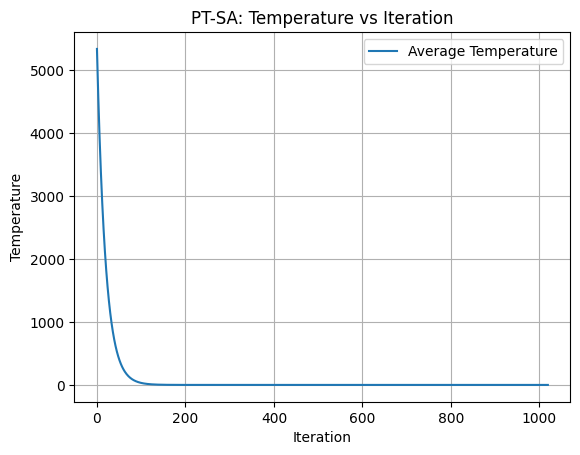

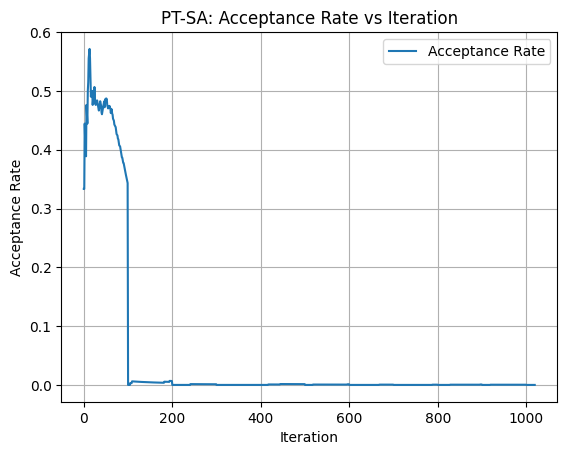

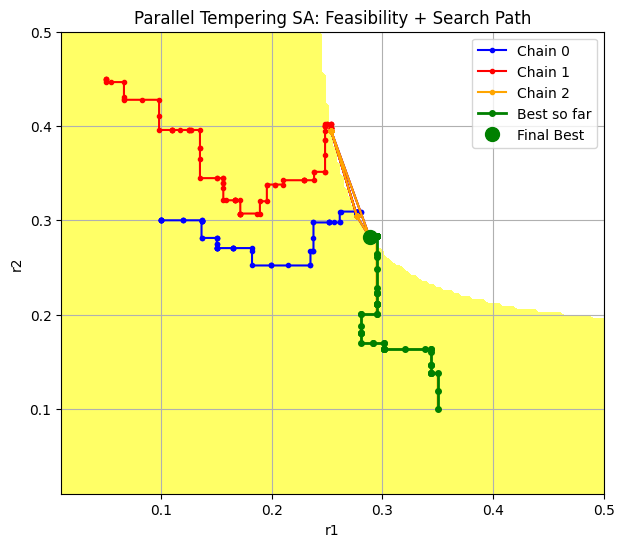

In [21]:
def plot_feasibility_and_paths(bounds, chain_paths, best_history, N=150, title="Parallel Tempering SA"):
    """
    White = feasible region, Yellow = infeasible.
    Overlays chain paths + best-history path.
    """
    r1_lin = np.linspace(bounds[0][0], bounds[0][1], N)
    r2_lin = np.linspace(bounds[1][0], bounds[1][1], N)
    R1, R2 = np.meshgrid(r1_lin, r2_lin)

    feas_mask = np.zeros_like(R1, dtype=bool)
    for i in range(N):
        for j in range(N):
            rr = [R1[i,j], R2[i,j]]
            g = nonlincon(rr)
            feas_mask[i,j] = np.all(g<=0)

    fig, ax = plt.subplots(figsize=(7,6))
    ax.contourf(R1, R2, feas_mask, levels=[-0.5,0.5], colors=["yellow","white"], alpha=0.6)

    # Plot chain paths
    color_cycle = ["blue","red","orange","purple","cyan","magenta","black"]
    for c_idx, path_c in enumerate(chain_paths):
        path_c = np.array(path_c)
        col = color_cycle[c_idx%len(color_cycle)]
        ax.plot(path_c[:,0], path_c[:,1], '-o', color=col, markersize=3, label=f"Chain {c_idx}")

    # Plot best history in green
    best_hist = np.array(best_history)
    ax.plot(best_hist[:,0], best_hist[:,1], '-o', color="green", linewidth=2, markersize=4, label="Best so far")
    ax.plot(best_hist[-1,0], best_hist[-1,1], 'o', color="green", markersize=10, label="Final Best")

    ax.set_xlim(bounds[0])
    ax.set_ylim(bounds[1])
    ax.set_xlabel("r1")
    ax.set_ylabel("r2")
    ax.set_title(title)
    ax.grid(True)
    ax.legend()
    plt.show()


if __name__=="__main__":
    # Example Parallel Tempering SA config
    pt_config = {
        "r0_list": [
            [0.1, 0.3],
            [0.05, 0.45],
            [0.35, 0.1]
        ],
        "T0_list": [1e4, 5e3, 1e3],
        "bounds": [(0.01,0.5),(0.01,0.5)],
        "max_iter": 2000,
        "swap_interval": 200,
        "adapt_interval": 100,
        "step_size_init": 0.02,
        "adapt_factor": 1.2,
        "no_improve_limit": 500,
        "min_temp": 1e-9,
        "cooling_rate": 0.95,
        "seed": 0
    }
    best_sol, best_val, logs = parallel_tempering_sa(pt_config)
    print("\n=== PARALLEL TEMPERING SA COMPLETE ===")
    print("Best solution found:", best_sol)
    print("Best energy (obj + penalty):", best_val)
    print("Objective alone:", obj(best_sol))
    print("Constraints:", nonlincon(best_sol))
    print("Feasible?", is_feasible(best_sol))

    # Plot temperature & acceptance
    plt.figure()
    plt.plot(logs["temp_history"], label="Average Temperature")
    plt.xlabel("Iteration")
    plt.ylabel("Temperature")
    plt.title("PT-SA: Temperature vs Iteration")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(logs["accept_history"], label="Acceptance Rate")
    plt.xlabel("Iteration")
    plt.ylabel("Acceptance Rate")
    plt.title("PT-SA: Acceptance Rate vs Iteration")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot feasibility region + path
    plot_feasibility_and_paths(
        bounds=pt_config["bounds"],
        chain_paths=logs["chain_paths"],
        best_history=logs["best_history"],
        N=150,
        title="Parallel Tempering SA: Feasibility + Search Path"
    )

NameError: name 'xBest' is not defined

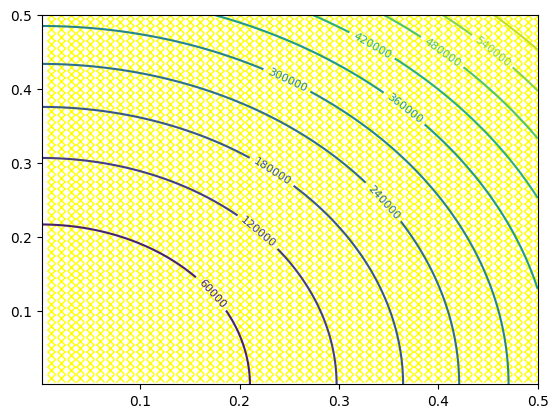

In [22]:

# Validation and contour plot
OK = []
for r1 in np.arange(0.01, 0.51, 0.01):
    for r2 in np.arange(0.01, 0.51, 0.01):
        r = np.array([r1, r2])
        g = nonlincon(r)
        if np.any(np.array(g) < 0):  # Check if any constraint is violated
            OK.append(r)

# Convert OK to NumPy array for easier plotting
OK = np.array(OK)

# Plot infeasible solutions
if OK.size > 0:
    plt.plot(OK[:, 0], OK[:, 1], 'x', label='unfeasible r',color="yellow")

# Draw contour for weight levels
r0_values = np.linspace(0.001, 0.5, 100)
r1_values = np.linspace(0.001, 0.5, 100)
R0, R1 = np.meshgrid(r0_values, r1_values)

# Compute objective values
Z = obj([R0, R1])
# Draw Contour
contour = plt.contour(R0, R1, Z, levels=10, cmap='viridis')
plt.clabel(contour, inline=True, fontsize=8)

# Mark the optimal point
plt.plot(xBest[0], xBest[1], 'ro', label='Optimal Point')
plt.text(
    xBest[0], xBest[1],
    f" ({xBest[0]:.4f}, {xBest[1]:.4f})",
    color='red', fontsize=13
)

# Plot settings
plt.xlabel('r_1')
plt.ylabel('r_2')
plt.legend()
plt.grid()
plt.show()
